In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as oj
import math
import pygsheets
import pickle as pkl
import pandas as pd
import seaborn as sns
import plotly.express as px
from collections import Counter
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import sys
import load_data
sys.path.append('modeling')
from viz import viz, viz_interactive
from modeling.fit_and_predict import add_preds
from functions import merge_data
from functions import update_severity_index as severity_index

NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
df_hospital = load_data.load_hospital_level()
df_county = load_data.load_county_level()
df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST, cached_dir='data') # adds keys like "Predicted Deaths 1-day"
df = merge_data.merge_county_and_hosp(df_county, df_hospital)

Loading BokehJS ...

In [8]:
df['Latitude'].isna().sum()

0

In [2]:
df = severity_index.add_severity_index(df, NUM_DAYS_LIST)
k = 3
s_hosp = f'Predicted Deaths Hospital {k}-day'
s_index = f'Severity {k}-day'
print('total hospitals', df.shape[0], Counter(df[s_index]))

total hospitals 5943 Counter({1: 2906, 2: 1519, 3: 1518})


**start with county-level death predictions**

In [ ]:
s = f'Predicted Deaths {3}-day' # tot_deaths
# s = 'tot_deaths'
num_days = 1
nonzero = df[s] > 0
plt.figure(dpi=300, figsize=(7, 3))
plt.plot(df_county[s].values, '.', ms=3)
plt.ylabel(s)
plt.xlabel('Counties')
plt.yscale('log')
plt.tight_layout()
plt.show()

**look at distribution of predicted deaths at hospitals**

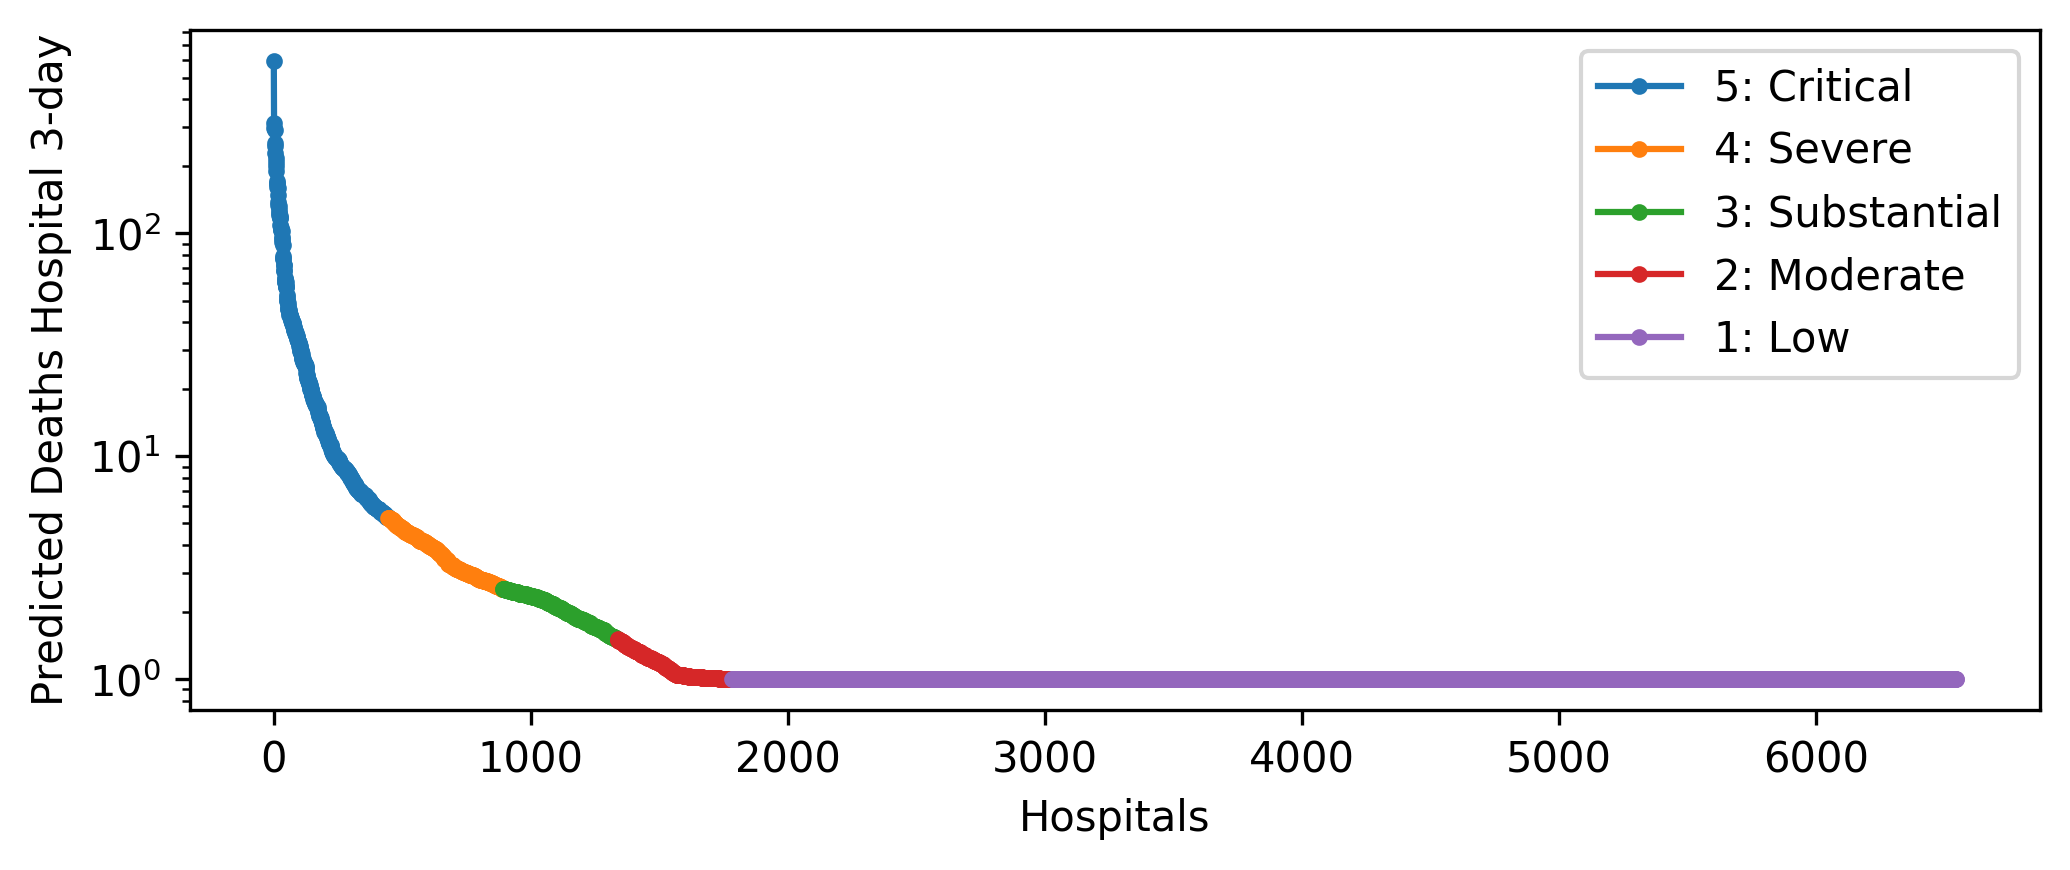

In [38]:
num_days = 1
plt.figure(dpi=300, figsize=(7, 3))

offset = 0
for i in [5, 4, 3, 2, 1]:
    idxs = (df[s_index] == i)
    plt.plot(np.arange(offset, offset + idxs.sum()), 
             np.clip(df[idxs][s_hosp].values, a_min=1, a_max=None), '.-', label=f'{i}: {severity_index.meanings[i]}')
    offset += idxs.sum()
plt.yscale('log')
plt.ylabel(s_hosp)
plt.xlabel('Hospitals')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.sort_values('Predicted Deaths Hospital 2-day', ascending=False)[['Hospital Name', 'StateName', 
                                                                    'Hospital Employees', 'tot_deaths',
                                                                    'Predicted Deaths Hospital 2-day']].head(30)

# adjustments

**different measures of hospital size are pretty consistent**

In [ ]:
plt.figure(dpi=500, figsize=(7, 3))
R, C = 1, 3
plt.subplot(R, C, 1)
plt.plot(df['Hospital Employees'], df['Total Average Daily Census'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Average Daily Census')

plt.subplot(R, C, 2)
plt.plot(df['Hospital Employees'], df['Total Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Beds')

plt.subplot(R, C, 3)
plt.plot(df['Hospital Employees'], df['ICU Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('ICU Beds')

plt.tight_layout()
plt.show()

**other measures are harder to parse...**

In [ ]:
ks = ['Predicted Deaths Hospital 2-day', "Hospital Employees", 'ICU Beds']
R, C = 1, len(ks)
plt.figure(dpi=300, figsize=(C * 3, R * 3))

for c in range(C):
    plt.subplot(R, C, c + 1)
    if c == 0:
        plt.ylabel('Total Occupancy Rate')
    plt.plot(df[ks[c]], df['Total Occupancy Rate'], '.', alpha=0.5)
    plt.xlabel(ks[c])

plt.tight_layout()
plt.show()

**different hospital types**

In [ ]:
plt.figure(dpi=500, figsize=(7, 3))
R, C = 1, 3
a = 0.5
s = s_hosp
plt.subplot(R, C, 1)
idxs = df.IsUrbanHospital == 1
plt.hist(df[idxs][s], label='Urban', alpha=a)
plt.hist(df[~idxs][s], label='Rural', alpha=a)
plt.ylabel('Num Hospitals')
plt.xlabel(s)
plt.yscale('log')
plt.legend()

plt.subplot(R, C, 2)
idxs = df.IsAcuteCareHospital == 1
plt.hist(df[idxs][s], label='Acute Care', alpha=a)
plt.hist(df[~idxs][s], label='Other', alpha=a)
plt.xlabel(s)
plt.yscale('log')
plt.legend()

plt.subplot(R, C, 3)
idxs = df.IsAcademicHospital == 1
plt.hist(df[idxs][s], label='Academic', alpha=a)
plt.hist(df[~idxs][s], label='Other', alpha=a)
plt.xlabel(s)
plt.yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

**rural areas have lower occupancy rates**

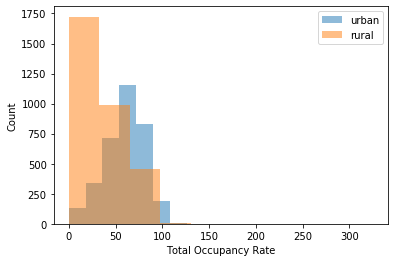

In [58]:
idxs = df.IsUrbanHospital == 1
plt.hist(df['Total Occupancy Rate'][idxs], label='urban', alpha=0.5)
plt.hist(df['Total Occupancy Rate'][~idxs], label='rural', alpha=0.5)
plt.xlabel('Total Occupancy Rate')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
ks = ['ICU Beds', 'Total Beds', 
      'Hospital Employees', 'Registered Nurses',
      'ICU Occupancy Rate', 'Total Occupancy Rate',
      'Mortality national comparison', 'Total Average Daily Census',
      
#       'IsAcademicHospital', 
      'IsUrbanHospital', 'IsAcuteCareHospital']
      
      

# ks += [f'Predicted Deaths {n}-day' for n in NUM_DAYS_LIST]
ks += [f'Predicted Deaths Hospital {n}-day' for n in NUM_DAYS_LIST]

# county-level stuff
# ks += ['unacast_n_grade', Hospital Employees in County', 'tot_deaths', 'tot_cases', 'PopulationDensityperSqMile2010'] 


viz.corrplot(df[ks], SIZE=6)

# look at top counties/hospitals

**hospitals per county**

In [ ]:
d = df

R, C = 1, 2
NUM_COUNTIES = 7
plt.figure(dpi=300, figsize=(7, 3.5))


plt.subplot(R, C, 1)
c = 'County Name'
county_names = d[c].unique()[:NUM_COUNTIES]
num_academic_hospitals = []
# d = df[outcome_keys + hospital_keys]
# d = d.sort_values('New Deaths', ascending=False)
for county in county_names:
    num_academic_hospitals.append(d[d[c] == county].shape[0])
plt.barh(county_names[::-1], num_academic_hospitals[::-1]) # reverse to plot top down
plt.xlabel('Number academic hospitals\n(for hospitals where we have data)')

plt.subplot(R, C, 2)
plt.barh(df_county.CountyName[:NUM_COUNTIES].values[::-1], df_county['Hospital Employees in County'][:NUM_COUNTIES][::-1]) # reverse to plot top down
plt.xlabel('# Hospital Employees')

plt.tight_layout()
plt.show()

In [ ]:
county_names = d[c].unique()[:NUM_COUNTIES]
R, C = 4, 1
plt.figure(figsize=(C * 3, R * 3), dpi=200)
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    cn = county_names[i]
    dc = d[d[c] == cn]
    plt.barh(dc['Hospital Name'][::-1], dc['Hospital Employees'][::-1])
    plt.title(cn)
    plt.xlabel('# Hospital Employees')
plt.tight_layout()
# plt.subplots_adjust(bottom=1)
plt.show()